## Import Packages

In [17]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

## Load File

In [3]:
df = pd.read_csv("retentiondata_case.csv")

## Drop columns

In [4]:
df = df.drop(columns=["acct_ref", "cust_ref"])

# drop rows wiht missing total billed, brand new customers with no bills yet
df = df.dropna(subset=["total_billed"])

## Fill in Missing values

In [5]:
df["recent_offer"]  = df["recent_offer"].fillna("none")
df["internet_tech"]  = df["internet_tech"].fillna("none")
df["internet_plan"]  = df["internet_plan"].fillna("none")

## X and Y predictors

In [8]:
Y = (df["left_flag"] == "Yes").astype(int)
X = df.drop(columns=["left_flag"])

## Feature Engineering

In [12]:
# tenure-safe division
X["tenure_mo_nonzero"] = X["tenure_mo"].clip(lower=1)

X["avg_monthly_billed"] = X["total_billed"] / X["tenure_mo_nonzero"]
X["avg_monthly_extra_data_fees"] = X["extra_data_fees_total"] / X["tenure_mo_nonzero"]
X["avg_monthly_long_dist_fees"] = X["long_dist_fees_total"] / X["tenure_mo_nonzero"]

# tenure buckets
X["tenure_group"] = np.where(
    X["tenure_mo"] <= 6, "0–6 months (New)",
    np.where(X["tenure_mo"] <= 24, "7–24 months (Mid)", "25+ months (Long)")
)

# interactions
X["is_month_to_month"] = (X["contract_term"] == "Month-to-month").astype(int)
X["early_tenure"] = (X["tenure_mo"] <= 6).astype(int)
X["early_mtm"] = X["is_month_to_month"] * X["early_tenure"]

# Calculates the ratio of extra fees that is the total billed
X["extra_fee_ratio"] = X["extra_data_fees_total"] / X["total_billed"].replace(0, np.nan)

# Calculates the ratio of long distance fees that is the total billed
X["ld_fee_ratio"] = X["long_dist_fees_total"] / X["total_billed"].replace(0, np.nan)

# internet flag
X["has_internet_service"] = (X["internet_plan"] != "none").astype(int)

# multiline handling
if "multi_line" in X.columns:
    ml = X["multi_line"].fillna("No").astype("string").str.strip()
    X["multi_line_flag"] = (ml == "Yes").astype(int)
    X["no_phone_service"] = (ml == "No phone service").astype(int)
    X = X.drop(columns=["multi_line"])
else:
    X["multi_line_flag"] = 0
    X["no_phone_service"] = 0

# service counts
stream_cols = ["stream_tv", "stream_movies", "stream_music"]
addon_cols = ["add_on_security", "add_on_backup", "add_on_protection", "premium_support", "unlimited_data_opt"]

X["count_of_reg_services"] = (
    + (X["home_phone"] == 1).astype(int) 
    + (X["multi_line_flag"] == 1).astype(int)
).astype(int) + X["has_internet_service"]

X["count_of_streaming_services"] = (X[stream_cols] == "Yes").sum(axis=1)
X["count_of_add_on_services"] = (X[addon_cols] == "Yes").sum(axis=1)

X["total_services"] = (
    X["count_of_reg_services"]
    + X["count_of_streaming_services"]
    + X["count_of_add_on_services"]
)


## Test Train Split

In [13]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     
    random_state=45,   # reproducibility
    shuffle=True,       # shuffle before splitting
    stratify=Y         # churn is ibalanced so stratifying this insures proportion of churn is consistent
)

# Check shapes
X_train.shape, X_test.shape

((3939, 49), (1689, 49))

## Preprocess

In [14]:
# Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Helps weight the data when churn % is imballenced
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()

# Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False   # drops the num and cat prefixs to variables
)

# Helps weight the data when churn % is imballenced
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()

## CV

In [15]:
# Stratified CV preserves class balance in each fold 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=33)   # may want to reduce the splits if running

## Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(Y_train)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=Y_train
)

class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {np.int64(0): np.float64(0.6810165975103735), np.int64(1): np.float64(1.8810888252148996)}


## XGBoost

In [75]:
# Helps weight the data when churn % is imballenced
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()

# Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic", #predicting a binary outcome, churn
        n_jobs= -1,          #cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=33,
        scale_pos_weight=scale_pos_weight   #applies class weighting since churn cases are more rare causing misclassifying a churned customer carries a higher penalty
    ))
])

#  Hyperparameter grid (more parameters here: https://federated-xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
param_grid = {
    "model__n_estimators": [400, 800],      # Number of boosting rounds
    "model__learning_rate": [0.03, 0.1],    # How much each new tree changes the model
    "model__max_depth": [3, 5],             # Maximum depth of each tree
    "model__min_child_weight": [1, 5],      # Minimum weight required in a leaf to allow a split
    "model__gamma": [0, 0.5],               # Minimum loss reduction required to make a split
    "model__subsample": [0.9],              # Fraction of rows sampled to build each tree
    "model__colsample_bytree": [0.9],       # Fraction of features sampled for each tree
    "model__reg_lambda": [1, 5],            # L2 penalty on leaf weights
    "model__reg_alpha": [0, 0.1],           # L1 penalty on leaf weights
}
   
# automatically tries many model settings, tests each one using cross-validation, and picks the settings that perform best on average AUC xgb_cv = GridSearchCV(
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=2,
    refit=True
)

# Fit 
xgb_cv.fit(X_train, Y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=33, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='median'))]),
                                                                         ['tenure_mo',
                                                                          'monthly_fee',
                                                                          'total_billed',
                                                                          'age_years',
                                                                          'dependents_count',
                                                                          'referrals_count',
                                                                          'avg_long_dist_fee',
                                                                          'avg_...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=2,
             param_grid={'model__colsample_bytree': [0.9],
                         'model__gamma': [0, 0.5],
                         'model__learning_rate': [0.03, 0.1],
                         'model__max_depth': [3, 5],
                         'model__min_child_weight': [1, 5],
                         'model__n_estimators': [400, 800],
                         'model__reg_alpha': [0, 0.1],
                         'model__reg_lambda': [1, 5],
                         'model__subsample': [0.9]},
             scoring='roc_auc')

## Evaluation

Best CV AUC: 0.8989644390017716
Best Params: {'model__colsample_bytree': 0.9, 'model__gamma': 0.5, 'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__reg_alpha': 0.1, 'model__reg_lambda': 5, 'model__subsample': 0.9}
Test ROC-AUC: 0.8928


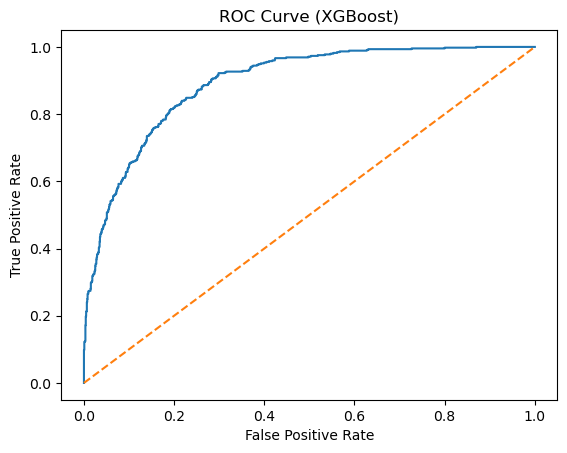

In [77]:
Y_proba = xgb_cv.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(Y_test, Y_proba)

print("Best CV AUC:", xgb_cv.best_score_)
print("Best Params:", xgb_cv.best_params_)
print("Test ROC-AUC:", round(test_auc, 4))

fpr, tpr, _ = roc_curve(Y_test, Y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.show()

## Cat Boost

In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=33)

cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=33,
        verbose=0,
        allow_writing_files=False,
        thread_count=-1,
        class_weights=class_weights
    ))
])

param_grid = {
    "model__depth": [4, 6],
    "model__learning_rate": [0.05, 0.1],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 5]
}

cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv_fast,
    scoring="roc_auc",
    n_jobs=1,
    refit=True
)

cat_cv.fit(X_train, Y_train, model__cat_features=cat_cols)

print("Best Params:", cat_cv.best_params_)
print("Best CV AUC:", round(cat_cv.best_score_, 3))

# Test evaluation
best_cat = cat_cv.best_estimator_
cat_proba = best_cat.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(Y_test, cat_proba)
print("Test ROC-AUC:", round(cat_auc, 3))

Best Params: {'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.05}
Best CV AUC: 0.902
Test ROC-AUC: 0.899


referrals_count         24.787534
dependents_count        14.952335
is_month_to_month       10.073474
has_dependents           5.133054
internet_plan            4.991793
contract_term            3.950674
tenure_mo                2.597395
monthly_fee              2.415371
tech_support_std         2.409586
tenure_group             2.288673
tenure_mo_nonzero        2.244524
long_dist_fees_total     1.939281
pay_method               1.664314
avg_monthly_billed       1.663564
age_years                1.656024
dtype: float64

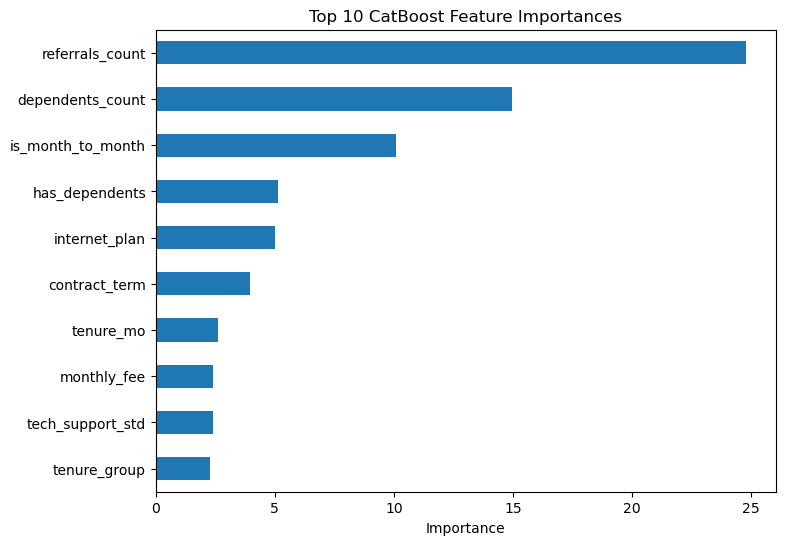

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Get best fitted CatBoost model from GridSearchCV pipeline
best_cat = cat_cv.best_estimator_.named_steps["model"]

# Feature names are the original columns (CatBoost uses raw features)
feature_names = X_train.columns

# Get CatBoost feature importance
imp = pd.Series(
    best_cat.get_feature_importance(),
    index=feature_names
).sort_values(ascending=False)

# Display top features
display(imp.head(15))

plt.figure(figsize=(8, 6))
imp.head(10).sort_values().plot(kind="barh", legend=False)
plt.title("Top 10 CatBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

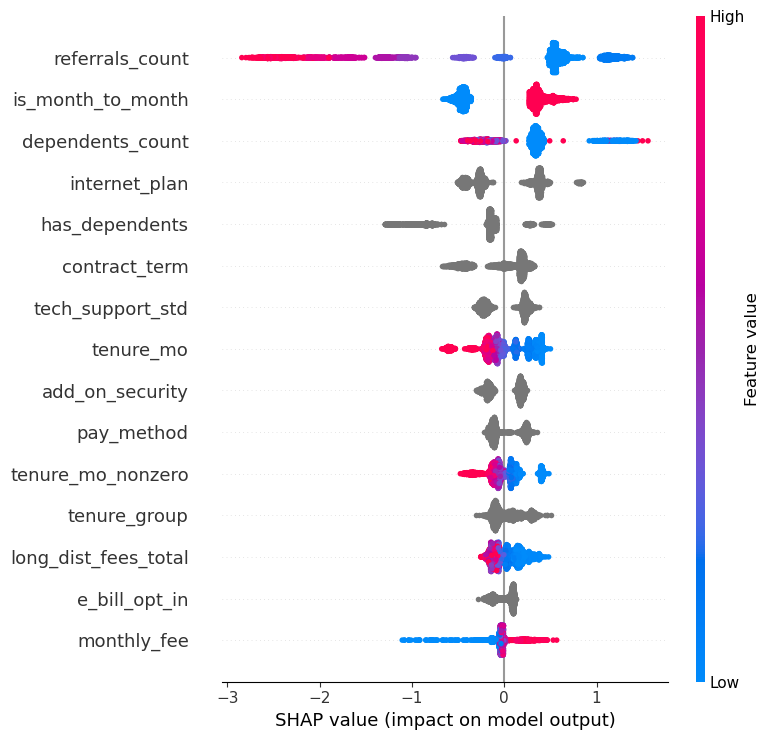

In [22]:
import shap

# 1) Get best fitted CatBoost model from GridSearchCV pipeline
best_cat = cat_cv.best_estimator_.named_steps["model"]

# 2) Feature names are the original DataFrame columns
feature_names = X_train.columns.to_list()

# 3) Create SHAP explainer for CatBoost
explainer = shap.TreeExplainer(best_cat)

# 4) Compute SHAP values for training set
shap_out = explainer(X_train)

# Convert to a SHAP matrix for the positive class (churn = 1)
if hasattr(shap_out, "values"):
    shap_values = shap_out.values
    if shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1]
else:
    shap_values = explainer.shap_values(X_train)
    # If returned as [class0, class1], take class 1
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

# 5) Beeswarm summary plot
shap.summary_plot(
    shap_values,
    X_train,
    max_display=15,
    show=True,
    feature_names=feature_names
)



## Random Forrest

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),   # same preprocessing as XGBoost
    ("model", RandomForestClassifier(
        n_estimators=500,          # number of trees
        max_depth=None,            # let trees grow fully
        min_samples_leaf=10,       # regularization to reduce overfitting
        class_weight="balanced",   # handles churn imbalance
        random_state=33,
        n_jobs=-1
    ))
])

rf_param_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [5, 10, 20],
}

rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_cv.fit(X_train, Y_train)

rf_proba = rf_cv.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(Y_test, rf_proba)

print("Random Forest Best CV AUC:", rf_cv.best_score_)
print("Random Forest Test AUC:", round(rf_auc, 4))
print("Best RF Params:", rf_cv.best_params_)


Random Forest Best CV AUC: 0.8798950813771957
Random Forest Test AUC: 0.8668
Best RF Params: {'model__max_depth': 10, 'model__min_samples_leaf': 5}


## LightGBM

[LightGBM] [Info] Number of positive: 1047, number of negative: 2892
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265804 -> initscore=-1.016019
[LightGBM] [Info] Start training from score -1.016019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\spenc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


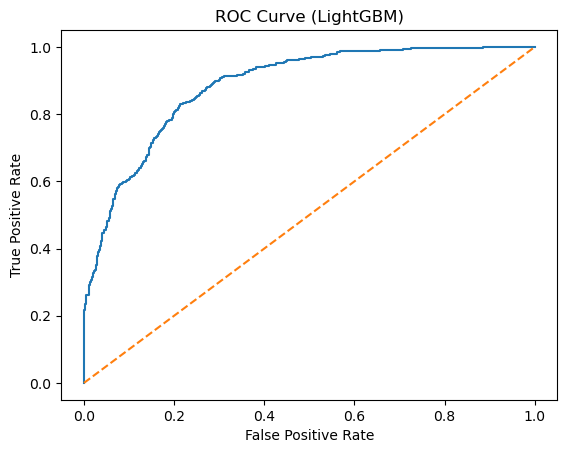

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

lgbm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LGBMClassifier(
        objective="binary",
        random_state=33,
        n_jobs=-1,
        is_unbalance=True,     # helps with class imbalance
        force_col_wise=True
    ))
])

param_grid = {
    "model__n_estimators": [400, 800],
    "model__learning_rate": [0.03, 0.1],
    "model__num_leaves": [31, 63],       # complexity (bigger = more complex)
    "model__min_child_samples": [20, 50],# regularization (bigger = more conservative)
    "model__subsample": [0.8, 1.0],      # row sampling
    "model__colsample_bytree": [0.8, 1.0]# feature sampling
}

lgbm_cv = GridSearchCV(
    estimator=lgbm_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

lgbm_cv.fit(X_train, Y_train)

Y_proba = lgbm_cv.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(Y_test, Y_proba)

print("LightGBM Best CV AUC:", lgbm_cv.best_score_)
print("LightGBM Best Params:", lgbm_cv.best_params_)
print("LightGBM Test ROC-AUC:", round(test_auc, 4))

fpr, tpr, _ = roc_curve(Y_test, Y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.show()

In [95]:
import pandas as pd
from sklearn.metrics import roc_auc_score

models = {
    "Random Forest": rf_cv,
    "XGBoost": xgb_cv,
    "LightGBM": lgbm_cv,
    "CatBoost": cat_cv
}

results = []

for name, model in models.items():
    # Predict churn probabilities on TEST set
    y_proba = model.predict_proba(X_test)[:, 1]

    # Compute Test ROC-AUC
    test_auc = roc_auc_score(Y_test, y_proba)

    results.append({
        "Model": name,
        "Test AUC": round(test_auc, 3)
    })

# Create final results table
results_df = (
    pd.DataFrame(results)
    .sort_values("Test AUC", ascending=False)
    .reset_index(drop=True)
)

results_df

C:\Users\spenc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Test AUC
0,CatBoost,0.899
1,XGBoost,0.893
2,LightGBM,0.885
3,Random Forest,0.867


C:\Users\spenc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


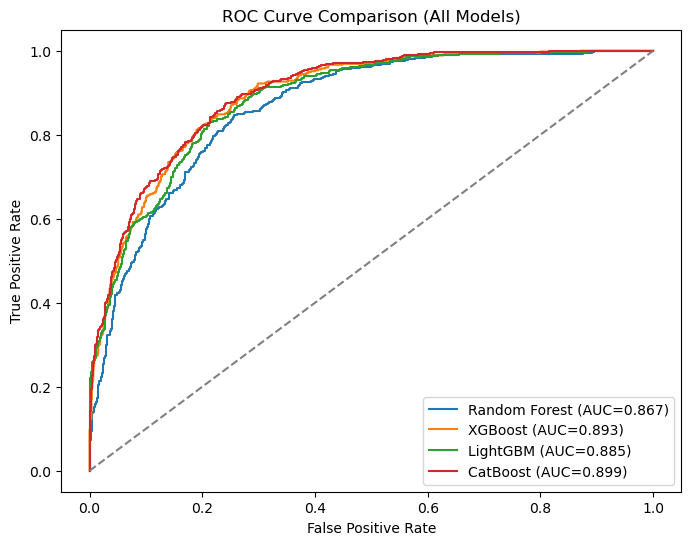

In [91]:
plt.figure(figsize=(8, 6))

for name, m in models.items():
    y_proba = m.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    auc = roc_auc_score(Y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (All Models)")
plt.legend()
plt.show()

In [24]:
holdout = pd.read_csv("retentiondata_case_holdout.csv")
print(holdout.describe(include='all'))

          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         1407          1407           1407  1407.000000       1407   
unique        1407          1407              2          NaN          2   
top     ACCT908192  CUST34262714             No          NaN        Yes   
freq             1             1            976          NaN       1282   
mean           NaN           NaN            NaN    32.074627        NaN   
std            NaN           NaN            NaN    24.739484        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    27.000000        NaN   
75%            NaN           NaN            NaN    56.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        1407          1407   

In [ ]:
holdout = holdout.drop(columns=["acct_ref", "cust_ref"])

# drop rows wiht missing total billed, brand new customers with no bills yet
holdout = holdout.dropna(subset=["total_billed"])

holdout["recent_offer"]  = holdout["recent_offer"].fillna("none")
holdout["internet_tech"]  = holdout["internet_tech"].fillna("none")
holdout["internet_plan"]  = holdout["internet_plan"].fillna("none")


In [ ]:
holdout_aligned = holdout.reindex(columns=X_train.columns)
cat_feature_indices = [holdout_aligned.columns.get_loc(c) for c in cat_cols if c in holdout_aligned.columns]

In [33]:


# tenure-safe division
holdout["tenure_mo_nonzero"] = holdout["tenure_mo"].clip(lower=1)

holdout["avg_monthly_billed"] = holdout["total_billed"] / holdout["tenure_mo_nonzero"]
holdout["avg_monthly_extra_data_fees"] = holdout["extra_data_fees_total"] / holdout["tenure_mo_nonzero"]
holdout["avg_monthly_long_dist_fees"] = holdout["long_dist_fees_total"] / holdout["tenure_mo_nonzero"]

# tenure buckets
holdout["tenure_group"] = np.where(
    holdout["tenure_mo"] <= 6, "0–6 months (New)",
    np.where(holdout["tenure_mo"] <= 24, "7–24 months (Mid)", "25+ months (Long)")
)

# interactions
holdout["is_month_to_month"] = (holdout["contract_term"] == "Month-to-month").astype(int)
holdout["early_tenure"] = (holdout["tenure_mo"] <= 6).astype(int)
holdout["early_mtm"] = holdout["is_month_to_month"] * holdout["early_tenure"]

# Calculates the ratio of extra fees that is the total billed
holdout["extra_fee_ratio"] = holdout["extra_data_fees_total"] / holdout["total_billed"].replace(0, np.nan)

# Calculates the ratio of long distance fees that is the total billed
holdout["ld_fee_ratio"] = holdout["long_dist_fees_total"] / holdout["total_billed"].replace(0, np.nan)

# internet flag
holdout["has_internet_service"] = (holdout["internet_plan"] != "none").astype(int)

# multiline handling
if "multi_line" in holdout.columns:
    ml = holdout["multi_line"].fillna("No").astype("string").str.strip()
    holdout["multi_line_flag"] = (ml == "Yes").astype(int)
    holdout["no_phone_service"] = (ml == "No phone service").astype(int)
    holdout = holdout.drop(columns=["multi_line"])
else:
    holdout["multi_line_flag"] = 0
    holdout["no_phone_service"] = 0

# service counts
holdout["count_of_reg_services"] = (
    (holdout["home_phone"] == 1).astype(int) +
    (holdout["multi_line_flag"] == 1).astype(int)
).astype(int) + holdout["has_internet_service"]

holdout["count_of_streaming_services"] = (holdout[stream_cols] == "Yes").sum(axis=1)
holdout["count_of_add_on_services"] = (holdout[addon_cols] == "Yes").sum(axis=1)

holdout["total_services"] = (
    holdout["count_of_reg_services"]
    + holdout["count_of_streaming_services"]
    + holdout["count_of_add_on_services"]
)


In [35]:
#Had to look up how to fix the grading since it didnt work with out CatBoost

from catboost import Pool
# Best estimator from GridSearch
best_pipe = cat_cv.best_estimator_

# Extract CatBoost model if wrapped in an sklearn Pipeline
best_model = best_pipe.named_steps["model"] if hasattr(best_pipe, "named_steps") else best_pipe

# Align holdout features to EXACT training schema (same columns + same order)
holdout_aligned = holdout.reindex(columns=X_train.columns)

# Build categorical feature indices (CatBoost wants indices for Pool)
cat_feature_indices = [
    holdout_aligned.columns.get_loc(c)
    for c in cat_cols
    if c in holdout_aligned.columns
]

# Create CatBoost Pool so strings like "Female" are treated as categorical
holdout_pool = Pool(holdout_aligned, cat_features=cat_feature_indices)

# Predict probabilities
Yholdout_proba = best_model.predict_proba(holdout_pool)[:, 1]

holdout["Yholdout_proba"] = Yholdout_proba

print(holdout[["Yholdout_proba"]].describe())

       Yholdout_proba
count     1404.000000
mean         0.376134
std          0.341537
min          0.000257
25%          0.043273
50%          0.282084
75%          0.710533
max          0.997557


In [40]:
holdout.to_csv("churn_holdout_scored_for_turnin.csv", index=False)